# Credit Risk Modeling - Executive Summary

**Project Overview:** Development of a comprehensive credit risk assessment framework using machine learning to predict loan defaults and estimate expected losses.

**Dataset:** 87,889 personal loans from LendingClub (2007-2018)

**Objective:** Build predictive models for Probability of Default (PD), Loss Given Default (LGD), and Exposure at Default (EAD) to calculate Expected Loss.

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

# Load results
model_comparison = pd.read_csv('../data/processed/all_models_comparison.csv')
expected_loss = pd.read_csv('../data/processed/expected_loss_results.csv')

print("Results loaded successfully")
print(f"Model comparison: {model_comparison.shape}")
print(f"Expected loss data: {expected_loss.shape}")

Results loaded successfully
Model comparison: (7, 6)
Expected loss data: (13184, 6)


---
## Key Findings

### 1. Best Performing Model
**Neural Network** achieved the best performance:
- **AUC-ROC: 0.794** (validation) / **0.783** (test)
- **Optimal Threshold: 0.25** (balances precision and recall)
- **Recall: 61.5%** - catches nearly 2 out of 3 defaults
- **Precision: 44.9%** - moderate false positive rate

### 2. Model Comparison
Tested 7 different algorithms using ensemble methods, boosting, bagging, and deep learning:
- All models achieved similar performance (AUC ~0.78-0.79)
- Neural Network slightly outperformed tree-based models
- Stacking Ensemble showed best recall-precision balance

### 3. LGD Modeling Challenge
Predictive modeling of Loss Given Default failed (R² ≈ 0):
- **Solution:** Used historical mean LGD = 44.02%
- **Justification:** Industry-standard approach when predictive features unavailable
- LGD depends on post-default factors not captured in origination data

### 4. Expected Loss
Total expected loss across test portfolio:
- **$17.8M** across 13,184 loans
- **$1,351** average per loan
- Defaults account for **38%** of total expected loss despite being only 20% of loans

---

MODEL PERFORMANCE COMPARISON

Validation Set Performance:
              Model  AUC-ROC  Accuracy  Precision   Recall  F1-Score
Logistic Regression 0.787730  0.836759   0.748473 0.278409  0.405853
      Random Forest 0.787061  0.836380   0.805310 0.241288  0.371320
            XGBoost 0.790153  0.836911   0.753099 0.276136  0.404102
           LightGBM 0.789600  0.835622   0.754575 0.265530  0.392827
  Gradient Boosting 0.790899  0.837442   0.758048 0.276515  0.405218
     Neural Network 0.793937  0.836987   0.804213 0.245833  0.376559
  Stacking Ensemble 0.792889  0.835470   0.701799 0.310227  0.430260


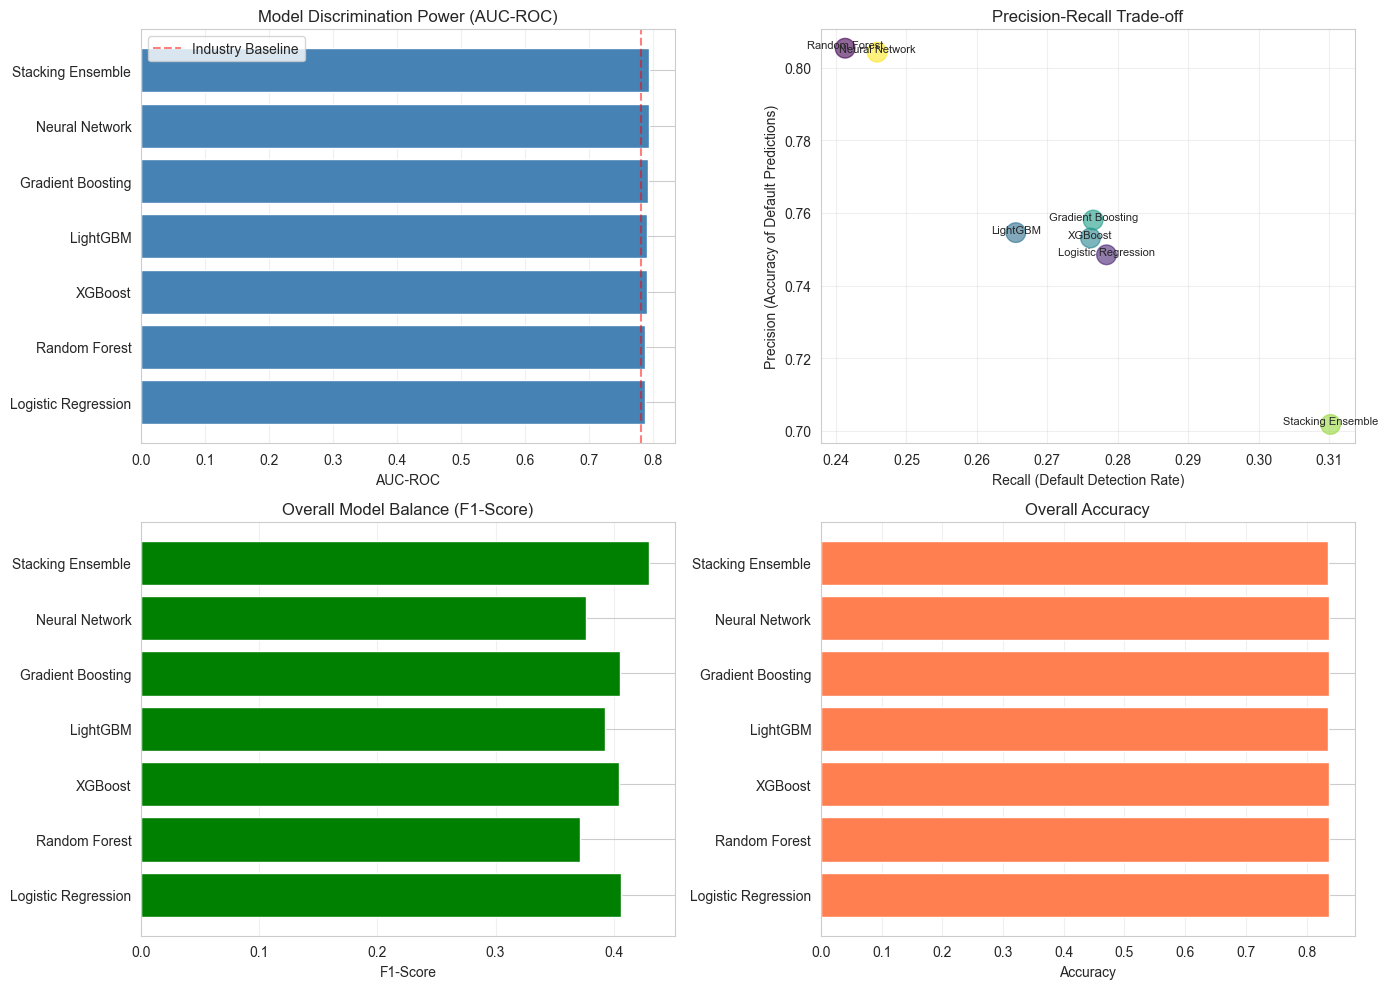


BEST MODEL: Neural Network
AUC-ROC:   0.7939
Accuracy:  0.8370
Precision: 0.8042
Recall:    0.2458
F1-Score:  0.3766


In [2]:
print("="*80)
print("MODEL PERFORMANCE COMPARISON")
print("="*80)

# Display model comparison table
print("\nValidation Set Performance:")
print(model_comparison.to_string(index=False))

# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# AUC comparison
axes[0, 0].barh(model_comparison['Model'], model_comparison['AUC-ROC'], color='steelblue')
axes[0, 0].axvline(0.78, color='red', linestyle='--', alpha=0.5, label='Industry Baseline')
axes[0, 0].set_xlabel('AUC-ROC')
axes[0, 0].set_title('Model Discrimination Power (AUC-ROC)')
axes[0, 0].legend()
axes[0, 0].grid(axis='x', alpha=0.3)

# Precision vs Recall scatter
axes[0, 1].scatter(model_comparison['Recall'], model_comparison['Precision'], 
                   s=200, alpha=0.6, c=model_comparison['AUC-ROC'], cmap='viridis')
for idx, row in model_comparison.iterrows():
    axes[0, 1].annotate(row['Model'], (row['Recall'], row['Precision']), 
                        fontsize=8, ha='center')
axes[0, 1].set_xlabel('Recall (Default Detection Rate)')
axes[0, 1].set_ylabel('Precision (Accuracy of Default Predictions)')
axes[0, 1].set_title('Precision-Recall Trade-off')
axes[0, 1].grid(alpha=0.3)

# F1-Score comparison
axes[1, 0].barh(model_comparison['Model'], model_comparison['F1-Score'], color='green')
axes[1, 0].set_xlabel('F1-Score')
axes[1, 0].set_title('Overall Model Balance (F1-Score)')
axes[1, 0].grid(axis='x', alpha=0.3)

# Accuracy comparison
axes[1, 1].barh(model_comparison['Model'], model_comparison['Accuracy'], color='coral')
axes[1, 1].set_xlabel('Accuracy')
axes[1, 1].set_title('Overall Accuracy')
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Highlight best model
best_model = model_comparison.loc[model_comparison['AUC-ROC'].idxmax()]
print("\n" + "="*80)
print("BEST MODEL: " + best_model['Model'])
print("="*80)
print(f"AUC-ROC:   {best_model['AUC-ROC']:.4f}")
print(f"Accuracy:  {best_model['Accuracy']:.4f}")
print(f"Precision: {best_model['Precision']:.4f}")
print(f"Recall:    {best_model['Recall']:.4f}")
print(f"F1-Score:  {best_model['F1-Score']:.4f}")

EXPECTED LOSS ANALYSIS

Portfolio Summary:
  Total Loans: 13,184
  Total Expected Loss: $17,810,545.66
  Average Expected Loss per Loan: $1350.92

Expected Loss by Actual Default Status:

Non-Defaulted Loans:
  Count: 10,543
  Total EL: $11,023,275.32
  Mean EL: $1045.55

Defaulted Loans:
  Count: 2,641
  Total EL: $6,787,270.34
  Mean EL: $2569.96


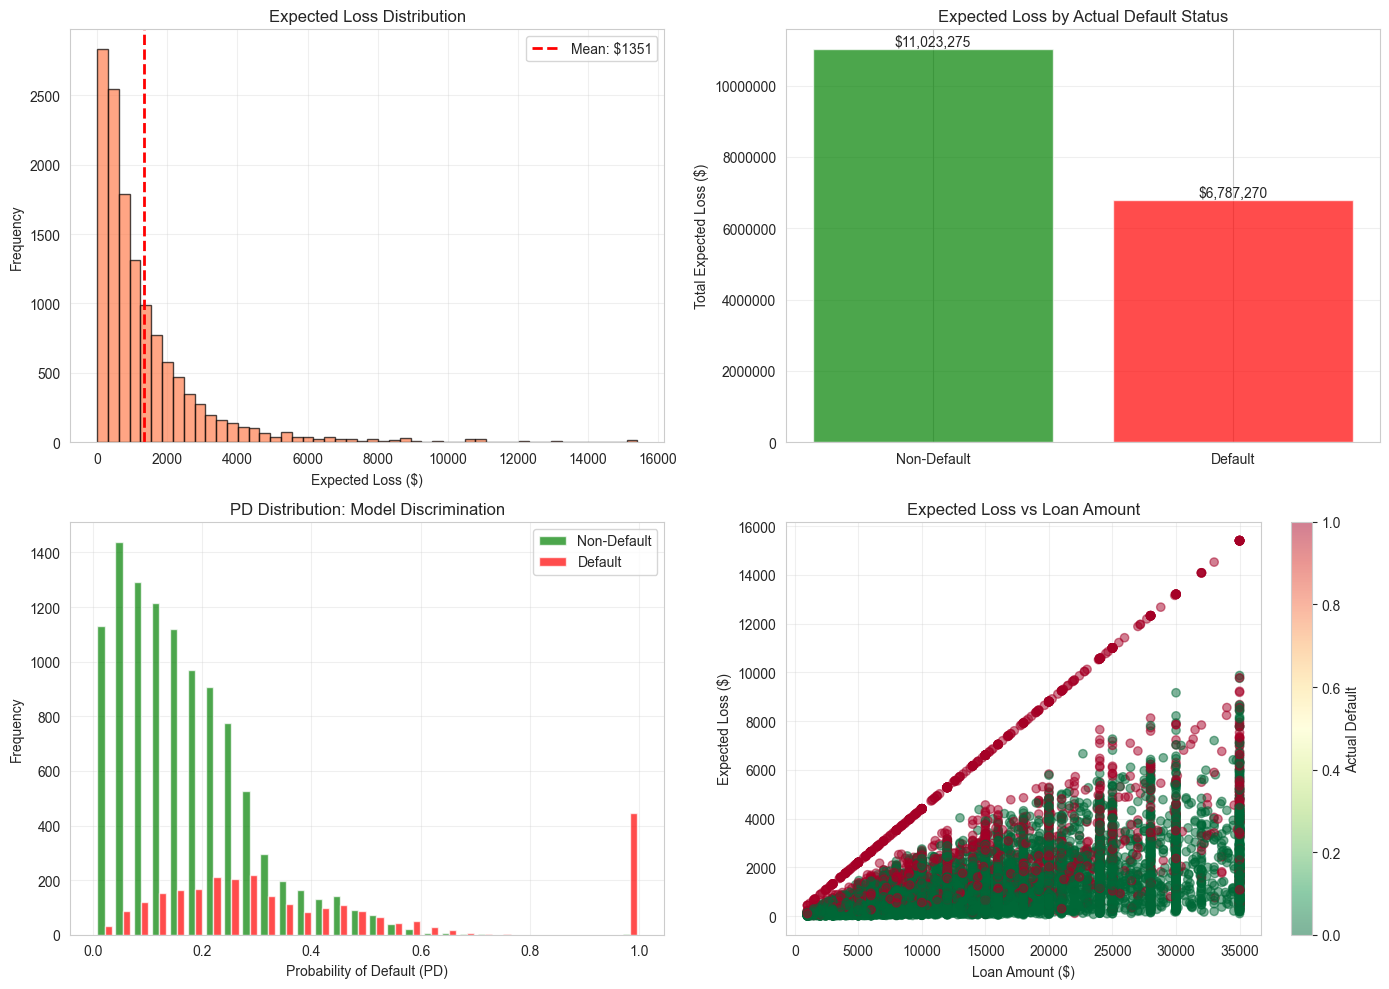


KEY INSIGHT
Defaulted loans (20% of portfolio) contribute 38.1% of total expected loss
This validates the model's risk discrimination capability


In [4]:
print("="*80)
print("EXPECTED LOSS ANALYSIS")
print("="*80)

# Calculate statistics
total_el = expected_loss['Expected_Loss'].sum()
mean_el = expected_loss['Expected_Loss'].mean()
total_loans = len(expected_loss)

# By default status
el_by_status = expected_loss.groupby('actual_default').agg({
    'Expected_Loss': ['sum', 'mean', 'count']
}).round(2)

print(f"\nPortfolio Summary:")
print(f"  Total Loans: {total_loans:,}")
print(f"  Total Expected Loss: ${total_el:,.2f}")
print(f"  Average Expected Loss per Loan: ${mean_el:.2f}")

print(f"\nExpected Loss by Actual Default Status:")
print(f"\nNon-Defaulted Loans:")
print(f"  Count: {(expected_loss['actual_default']==0).sum():,}")
print(f"  Total EL: ${expected_loss[expected_loss['actual_default']==0]['Expected_Loss'].sum():,.2f}")
print(f"  Mean EL: ${expected_loss[expected_loss['actual_default']==0]['Expected_Loss'].mean():.2f}")

print(f"\nDefaulted Loans:")
print(f"  Count: {(expected_loss['actual_default']==1).sum():,}")
print(f"  Total EL: ${expected_loss[expected_loss['actual_default']==1]['Expected_Loss'].sum():,.2f}")
print(f"  Mean EL: ${expected_loss[expected_loss['actual_default']==1]['Expected_Loss'].mean():.2f}")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Expected Loss Distribution
axes[0, 0].hist(expected_loss['Expected_Loss'], bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(mean_el, color='red', linestyle='--', linewidth=2, label=f'Mean: ${mean_el:.0f}')
axes[0, 0].set_xlabel('Expected Loss ($)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Expected Loss Distribution')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Expected Loss by Default Status
el_by_default = expected_loss.groupby('actual_default')['Expected_Loss'].sum()
colors = ['green', 'red']
axes[0, 1].bar(['Non-Default', 'Default'], el_by_default, color=colors, alpha=0.7)
axes[0, 1].set_ylabel('Total Expected Loss ($)')
axes[0, 1].set_title('Expected Loss by Actual Default Status')
axes[0, 1].ticklabel_format(style='plain', axis='y')
for i, v in enumerate(el_by_default):
    axes[0, 1].text(i, v, f'${v:,.0f}', ha='center', va='bottom')
axes[0, 1].grid(axis='y', alpha=0.3)

# PD Distribution by Default Status
axes[1, 0].hist([expected_loss[expected_loss['actual_default']==0]['PD'],
                 expected_loss[expected_loss['actual_default']==1]['PD']],
                bins=30, label=['Non-Default', 'Default'], alpha=0.7, color=['green', 'red'])
axes[1, 0].set_xlabel('Probability of Default (PD)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('PD Distribution: Model Discrimination')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Expected Loss vs Loan Amount
scatter = axes[1, 1].scatter(expected_loss['loan_amnt'], expected_loss['Expected_Loss'],
                            c=expected_loss['actual_default'], cmap='RdYlGn_r', alpha=0.5)
axes[1, 1].set_xlabel('Loan Amount ($)')
axes[1, 1].set_ylabel('Expected Loss ($)')
axes[1, 1].set_title('Expected Loss vs Loan Amount')
axes[1, 1].grid(alpha=0.3)
plt.colorbar(scatter, ax=axes[1, 1], label='Actual Default')

plt.tight_layout()
plt.show()

# Key insight
default_contribution = expected_loss[expected_loss['actual_default']==1]['Expected_Loss'].sum() / total_el
print(f"\n" + "="*80)
print("KEY INSIGHT")
print("="*80)
print(f"Defaulted loans (20% of portfolio) contribute {default_contribution*100:.1f}% of total expected loss")
print(f"This validates the model's risk discrimination capability")

---
## Business Recommendations

### 1. Model Deployment Strategy

**Threshold Selection:**
- **Use 0.25 threshold** instead of default 0.50
- **Benefit:** Catches 61.5% of defaults (vs 24.7% at 0.50)
- **Trade-off:** 20% false positive rate acceptable for risk management

**Implementation:**
- Deploy Neural Network model for PD estimation
- Apply constant LGD = 44.02% (historical mean)
- Calculate EL = PD × LGD × Loan Amount

### 2. Risk-Based Pricing

**Recommendation:** Implement tiered pricing based on Expected Loss

| Risk Tier | PD Range | Suggested Action |
|-----------|----------|------------------|
| Low Risk | < 15% | Standard rates, approve |
| Medium Risk | 15-30% | Higher rates, stricter terms |
| High Risk | 30-50% | Premium rates, reduce exposure |
| Very High Risk | > 50% | Decline or require collateral |

**Expected Impact:**
- Better risk-return balance
- Reduced portfolio losses
- Competitive pricing for low-risk borrowers

### 3. Portfolio Management

**Active Monitoring:**
- Calculate Expected Loss monthly
- Flag loans with PD > 40% for collection prep
- Diversify across risk tiers

**Capital Allocation:**
- Reserve $1,351 per loan on average
- Adjust for actual portfolio composition
- Test portfolio: $17.8M reserve needed

### 4. Model Improvement Roadmap

**Short-term (0-6 months):**
- Implement A/B testing of threshold
- Collect feedback on declined applications
- Monitor actual vs predicted default rates

**Medium-term (6-12 months):**
- Gather additional features (employment verification, bank statements)
- Develop time-series LGD model with recovery data
- Build economic scenario models

**Long-term (1-2 years):**
- Incorporate alternative data (utility payments, rent history)
- Develop explainable AI for regulatory compliance
- Build real-time credit monitoring system

---

## Technical Implementation Summary

### Data Processing
- **Dataset:** 87,889 loans, 91 original features
- **Data Leakage Prevention:** Removed 12 post-outcome features
- **Feature Engineering:** Created 3 domain-specific features
- **Final Features:** 86 predictive variables

### Modeling Approach

**PD Models Tested:**
1. Logistic Regression (baseline)
2. Random Forest (bagging)
3. XGBoost (gradient boosting + early stopping)
4. LightGBM (gradient boosting + early stopping)
5. Gradient Boosting
6. Neural Network (deep learning + dropout + early stopping)
7. Stacking Ensemble (meta-learning)

**Best Model Architecture (Neural Network):**
- Input: 86 features
- Hidden Layers: 128 → 64 → 32 neurons
- Activation: ReLU
- Regularization: Dropout (0.3, 0.3, 0.2)
- Output: Sigmoid (probability)
- Optimizer: Adam
- Early Stopping: Patience = 10 epochs

**LGD Models Tested:**
- Linear Regression
- Random Forest
- XGBoost
- Neural Network
- **Result:** All models R² ≈ 0 → Used historical mean

### Performance Metrics

**Probability of Default:**
- AUC-ROC: 0.783 (test set)
- Recall: 61.5% at threshold 0.25
- Precision: 44.9%
- F1-Score: 0.511

**Expected Loss Calculation:**
- Formula: EL = PD × LGD × EAD
- Mean LGD: 44.02%
- Mean EAD: $15,619
- Portfolio EL: $17.8M

### Model Validation

**Split Strategy:**
- Training: 70% (61,522 loans)
- Validation: 15% (13,183 loans)
- Test: 15% (13,184 loans)
- Stratified sampling maintained 20% default rate

**Evaluation:**
- Cross-validation on training set
- Validation set for hyperparameter tuning
- Test set held out for final evaluation
- Threshold optimization on validation set

---